# Import the following libraries

In [72]:
import pandas as pd
import numpy as np

from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
import nltk

import plotly.graph_objects as go
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from PIL import Image 

import spacy
from spacy.lang.en.stop_words import STOP_WORDS
nlp = spacy.load('en_core_web_sm')


from datetime import datetime
import re 

from collections import Counter
import string
import scipy.sparse

from gensim import corpora
from gensim.models.ldamulticore import LdaMulticore
import pyLDAvis.gensim
from gensim.models import CoherenceModel
from gensim import matutils

pd.set_option('display.max_columns', 200)
pd.set_option('display.max_colwidth', 300)

import pickle
import warnings
warnings.filterwarnings("ignore")
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

# Data processing

In [2]:
# Combining the datasets of the five brands
cars = [ 'Audi','BMW',
       'mercedes-benz','infiniti','lexus']

In [3]:
# A for loop to add all the car csv files to a list
paths = ['Scraped_Car_Review_{}.csv'.format(make) for make in cars ]
type(paths) 

# Alternatively
# for make in cars:
#     paths.append('Scrapped_Car_Review_{}.csv'.format(make))

list

In [4]:
# using list comprehension to concatnate the 5 csv files
df_list = [pd.read_csv(path,index_col=False, encoding = 'utf8', engine='python') for path in paths]

# Alternatively
# for path in paths:
#     df_list.append(pd.read_csv(path, encoding = 'utf8', engine='python'))
    
brand_df = pd.concat(df_list)
brand_df.head()

,Unnamed: 0,Review_Date,Author_Name,Vehicle_Title,Review_Title,Review,Rating
0,0,on 07/11/18 19:05 PM (PDT),ARLE,2018 Audi SQ5 SUV 3.0T Prestige quattro 4dr SUV AWD (3.0L 6cyl Turbo 8A),BEST ALL AROUND PURPOSE CROSSOVER SUV,"I have never seen or driven a car like this before. I've owned BMW 3, 5, and 7 series, Porsche 911, and Mercedes SL 55 and a Honda Pilot. The SQ5 is a combination of all of them. Its rides very comfortably, very stable, and quiet, sporty and with a lot of power and torque. Its a get up and ...",5.0
1,1,on 06/24/18 12:50 PM (PDT),Mark Weiner,2018 Audi SQ5 SUV 3.0T Prestige quattro 4dr SUV AWD (3.0L 6cyl Turbo 8A),Best car,This is a wonderful car. The technology is very adaptable the car most comfortable and is great looking. Many nice details. Waiting to see gas mileage,5.0
2,2,on 05/02/18 11:45 AM (PDT),mycwf.pic,2018 Audi SQ5 SUV 3.0T Premium Plus quattro 4dr SUV AWD (3.0L 6cyl Turbo 8A),Great Buy,Do your home work,5.0
3,3,on 12/07/17 14:12 PM (PST),Rich,2018 Audi SQ5 SUV 3.0T Premium Plus quattro 4dr SUV AWD (3.0L 6cyl Turbo 8A),Fun Car,Great ride. Loaded with technology. Steering not as tight as x5,5.0
4,4,on 10/25/17 15:54 PM (PDT),Al,2018 Audi SQ5 SUV 3.0T Prestige quattro 4dr SUV AWD (3.0L 6cyl Turbo 8A),Best luxury SUV w/ perfect comfort/sport balance,"Very happy with choosing the 2018 Audi SQ5 prestige. Before buying, I compared it to the new F -Pace S, XC60 T8, 43 AMG, and upcoming redesigned X3 M40i. With Audi SQ5's standard adaptive dampers, you get the best comfort, but also great sportiness when desired. The volvo is for my taste too s...",5.0


In [5]:
# Reset the index here
brand_df.reset_index(inplace=True, drop=True)

In [6]:
# Make a copy of the dataframe (I might need this original datafram in future)
brand = brand_df.copy()

In [7]:
# Drop the unammed column and Author _name column
brand.drop(['Unnamed: 0','Author_Name'],axis=1,inplace=True)
# CHeck the data info
brand.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41520 entries, 0 to 41519
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Review_Date    33956 non-null  object 
 1   Vehicle_Title  31938 non-null  object 
 2   Review_Title   31934 non-null  object 
 3   Review         31938 non-null  object 
 4   Rating         29920 non-null  float64
dtypes: float64(1), object(4)
memory usage: 1.6+ MB


In [8]:
# Check for nun values
brand.isnull().sum()

Review_Date       7564
Vehicle_Title     9582
Review_Title      9586
Review            9582
Rating           11600
dtype: int64

In [9]:
# use interpolate to get the nearest rating score 
brand['Rating'] = brand['Rating'].interpolate()

In [10]:
# Join the Review_Title and Review columns 
brand["review"] = brand["Review_Title"].map(str) + brand["Review"]

In [11]:
# droping the rows with nun review
brand.dropna(axis=0, how='all', subset=['Review'], inplace=True)
brand.head()

,Review_Date,Vehicle_Title,Review_Title,Review,Rating,review
0,on 07/11/18 19:05 PM (PDT),2018 Audi SQ5 SUV 3.0T Prestige quattro 4dr SUV AWD (3.0L 6cyl Turbo 8A),BEST ALL AROUND PURPOSE CROSSOVER SUV,"I have never seen or driven a car like this before. I've owned BMW 3, 5, and 7 series, Porsche 911, and Mercedes SL 55 and a Honda Pilot. The SQ5 is a combination of all of them. Its rides very comfortably, very stable, and quiet, sporty and with a lot of power and torque. Its a get up and ...",5.0,"BEST ALL AROUND PURPOSE CROSSOVER SUV I have never seen or driven a car like this before. I've owned BMW 3, 5, and 7 series, Porsche 911, and Mercedes SL 55 and a Honda Pilot. The SQ5 is a combination of all of them. Its rides very comfortably, very stable, and quiet, sporty and with a lot o..."
1,on 06/24/18 12:50 PM (PDT),2018 Audi SQ5 SUV 3.0T Prestige quattro 4dr SUV AWD (3.0L 6cyl Turbo 8A),Best car,This is a wonderful car. The technology is very adaptable the car most comfortable and is great looking. Many nice details. Waiting to see gas mileage,5.0,Best car This is a wonderful car. The technology is very adaptable the car most comfortable and is great looking. Many nice details. Waiting to see gas mileage
2,on 05/02/18 11:45 AM (PDT),2018 Audi SQ5 SUV 3.0T Premium Plus quattro 4dr SUV AWD (3.0L 6cyl Turbo 8A),Great Buy,Do your home work,5.0,Great Buy Do your home work
3,on 12/07/17 14:12 PM (PST),2018 Audi SQ5 SUV 3.0T Premium Plus quattro 4dr SUV AWD (3.0L 6cyl Turbo 8A),Fun Car,Great ride. Loaded with technology. Steering not as tight as x5,5.0,Fun Car Great ride. Loaded with technology. Steering not as tight as x5
4,on 10/25/17 15:54 PM (PDT),2018 Audi SQ5 SUV 3.0T Prestige quattro 4dr SUV AWD (3.0L 6cyl Turbo 8A),Best luxury SUV w/ perfect comfort/sport balance,"Very happy with choosing the 2018 Audi SQ5 prestige. Before buying, I compared it to the new F -Pace S, XC60 T8, 43 AMG, and upcoming redesigned X3 M40i. With Audi SQ5's standard adaptive dampers, you get the best comfort, but also great sportiness when desired. The volvo is for my taste too s...",5.0,"Best luxury SUV w/ perfect comfort/sport balance Very happy with choosing the 2018 Audi SQ5 prestige. Before buying, I compared it to the new F -Pace S, XC60 T8, 43 AMG, and upcoming redesigned X3 M40i. With Audi SQ5's standard adaptive dampers, you get the best comfort, but also great sportine..."


In [12]:
# Check if we still have nun values
brand.isnull().sum()

Review_Date      0
Vehicle_Title    0
Review_Title     4
Review           0
Rating           0
review           0
dtype: int64

In [13]:
# check the data type
brand.info()

<class 'pandas.core.frame.DataFrame'>
Index: 31938 entries, 0 to 41519
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Review_Date    31938 non-null  object 
 1   Vehicle_Title  31938 non-null  object 
 2   Review_Title   31934 non-null  object 
 3   Review         31938 non-null  object 
 4   Rating         31938 non-null  float64
 5   review         31938 non-null  object 
dtypes: float64(1), object(5)
memory usage: 1.7+ MB


In [14]:
# spliting the Vehicle_title into year, make and model column
brand['year'] = brand.Vehicle_Title.str.split(' ').apply(lambda x:x[0])
brand['make'] = brand.Vehicle_Title.str.split(' ').apply(lambda x:x[1])
brand['model'] = brand.Vehicle_Title.str.split(' ').apply(lambda x:x[2])
brand.head()

,Review_Date,Vehicle_Title,Review_Title,Review,Rating,review,year,make,model
0,on 07/11/18 19:05 PM (PDT),2018 Audi SQ5 SUV 3.0T Prestige quattro 4dr SUV AWD (3.0L 6cyl Turbo 8A),BEST ALL AROUND PURPOSE CROSSOVER SUV,"I have never seen or driven a car like this before. I've owned BMW 3, 5, and 7 series, Porsche 911, and Mercedes SL 55 and a Honda Pilot. The SQ5 is a combination of all of them. Its rides very comfortably, very stable, and quiet, sporty and with a lot of power and torque. Its a get up and ...",5.0,"BEST ALL AROUND PURPOSE CROSSOVER SUV I have never seen or driven a car like this before. I've owned BMW 3, 5, and 7 series, Porsche 911, and Mercedes SL 55 and a Honda Pilot. The SQ5 is a combination of all of them. Its rides very comfortably, very stable, and quiet, sporty and with a lot o...",2018,Audi,SQ5
1,on 06/24/18 12:50 PM (PDT),2018 Audi SQ5 SUV 3.0T Prestige quattro 4dr SUV AWD (3.0L 6cyl Turbo 8A),Best car,This is a wonderful car. The technology is very adaptable the car most comfortable and is great looking. Many nice details. Waiting to see gas mileage,5.0,Best car This is a wonderful car. The technology is very adaptable the car most comfortable and is great looking. Many nice details. Waiting to see gas mileage,2018,Audi,SQ5
2,on 05/02/18 11:45 AM (PDT),2018 Audi SQ5 SUV 3.0T Premium Plus quattro 4dr SUV AWD (3.0L 6cyl Turbo 8A),Great Buy,Do your home work,5.0,Great Buy Do your home work,2018,Audi,SQ5
3,on 12/07/17 14:12 PM (PST),2018 Audi SQ5 SUV 3.0T Premium Plus quattro 4dr SUV AWD (3.0L 6cyl Turbo 8A),Fun Car,Great ride. Loaded with technology. Steering not as tight as x5,5.0,Fun Car Great ride. Loaded with technology. Steering not as tight as x5,2018,Audi,SQ5
4,on 10/25/17 15:54 PM (PDT),2018 Audi SQ5 SUV 3.0T Prestige quattro 4dr SUV AWD (3.0L 6cyl Turbo 8A),Best luxury SUV w/ perfect comfort/sport balance,"Very happy with choosing the 2018 Audi SQ5 prestige. Before buying, I compared it to the new F -Pace S, XC60 T8, 43 AMG, and upcoming redesigned X3 M40i. With Audi SQ5's standard adaptive dampers, you get the best comfort, but also great sportiness when desired. The volvo is for my taste too s...",5.0,"Best luxury SUV w/ perfect comfort/sport balance Very happy with choosing the 2018 Audi SQ5 prestige. Before buying, I compared it to the new F -Pace S, XC60 T8, 43 AMG, and upcoming redesigned X3 M40i. With Audi SQ5's standard adaptive dampers, you get the best comfort, but also great sportine...",2018,Audi,SQ5


In [15]:
# taking only the date out from the Review_date column and putting in in a new column (date)
brand['date'] = brand['Review_Date'].str.extract(r"(\d{1,2}[/. ](?:\d{1,2}|January|Jan)[/. ]\d{2}(?:\d{2})?)")

# Change the date column to datetime
brand['date'] =  pd.to_datetime(brand['date'],format='%m/%d/%y')

In [16]:
# Drop all the unwanted columns
brand.drop(['Review_Date','Vehicle_Title','Review_Title','Review'],axis=1,inplace=True)

In [17]:
# Converting rating to int
brand['Rating'] = brand['Rating'].astype(int)

display(brand.info())

<class 'pandas.core.frame.DataFrame'>
Index: 31938 entries, 0 to 41519
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Rating  31938 non-null  int32         
 1   review  31938 non-null  object        
 2   year    31938 non-null  object        
 3   make    31938 non-null  object        
 4   model   31938 non-null  object        
 5   date    31938 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int32(1), object(4)
memory usage: 1.6+ MB


None

In [18]:
# Extract review year, month and day name 
brand['review_year'] = brand.date.dt.year
brand['month'] = brand.date.dt.month
brand['day'] = brand.date.dt.day
brand['week_day_name'] = brand.date.dt.day_name()


In [19]:
brand.head()

,Rating,review,year,make,model,date,review_year,month,day,week_day_name
0,5,"BEST ALL AROUND PURPOSE CROSSOVER SUV I have never seen or driven a car like this before. I've owned BMW 3, 5, and 7 series, Porsche 911, and Mercedes SL 55 and a Honda Pilot. The SQ5 is a combination of all of them. Its rides very comfortably, very stable, and quiet, sporty and with a lot o...",2018,Audi,SQ5,2018-07-11,2018,7,11,Wednesday
1,5,Best car This is a wonderful car. The technology is very adaptable the car most comfortable and is great looking. Many nice details. Waiting to see gas mileage,2018,Audi,SQ5,2018-06-24,2018,6,24,Sunday
2,5,Great Buy Do your home work,2018,Audi,SQ5,2018-05-02,2018,5,2,Wednesday
3,5,Fun Car Great ride. Loaded with technology. Steering not as tight as x5,2018,Audi,SQ5,2017-12-07,2017,12,7,Thursday
4,5,"Best luxury SUV w/ perfect comfort/sport balance Very happy with choosing the 2018 Audi SQ5 prestige. Before buying, I compared it to the new F -Pace S, XC60 T8, 43 AMG, and upcoming redesigned X3 M40i. With Audi SQ5's standard adaptive dampers, you get the best comfort, but also great sportine...",2018,Audi,SQ5,2017-10-25,2017,10,25,Wednesday


In [20]:
# PICKLE THE DATAFRAME
brand.to_pickle("brand_with_part_of_year.pkl")

In [21]:
# To see the percentage of each brands review in the dataset
brand_review_pct = brand['make'].value_counts(normalize = True).round(2) * 100 
brand_review_pct

make
BMW              25.0
Mercedes-Benz    23.0
Lexus            19.0
Audi             19.0
INFINITI         13.0
Name: proportion, dtype: float64

In [22]:
# create a Dataframe for the count of reviews of each brand
brand_review_count = brand.groupby('make').count()['review'].reset_index()
brand_review_count

,make,review
0,Audi,6043
1,BMW,8060
2,INFINITI,4307
3,Lexus,6153
4,Mercedes-Benz,7375


In [23]:
# Using plotly to create Barchat
bar_go = go.Bar(x = brand_review_count['make'], y = brand_review_count['review'], name='Review count')
fig = go.Figure(
    data=[bar_go],
    layout=go.Layout(width=1000, height=600, title='Brand Review Count', xaxis_title='make', yaxis_title='Review count'))
fig.show()

In [24]:
# the count of each brand according to their rating
grouped_brand = brand.groupby([brand.make, brand.Rating]).size().reset_index().rename(columns = {0: 'counts'})
grouped_brand

,make,Rating,counts
0,Audi,1,95
1,Audi,2,238
2,Audi,3,673
3,Audi,4,3153
4,Audi,5,1884
5,BMW,1,147
6,BMW,2,290
7,BMW,3,743
8,BMW,4,4500
9,BMW,5,2380


In [25]:
# Remove the numbers from the review
brand['review'] = brand['review'].apply(lambda x: re.sub(r'[^A-Za-z\s]', '', x))

# Convert the reviews to lowercase
brand['review'] = brand['review'].map(lambda x: x.lower())
brand.review

0        best all around purpose crossover suv i have never seen or driven a car like this before  ive owned bmw   and  series porsche  and mercedes sl  and a honda pilot  the sq  is a combination of all of them  its rides very comfortably very stable and quiet sporty and with a lot of power and torque i...
1                                                                                                                                                      best car this is a wonderful car  the technology is very adaptable the car most comfortable and is great looking many nice details waiting to see gas mileage
2                                                                                                                                                                                                                                                                                        great buy do your home work
3                                                                        

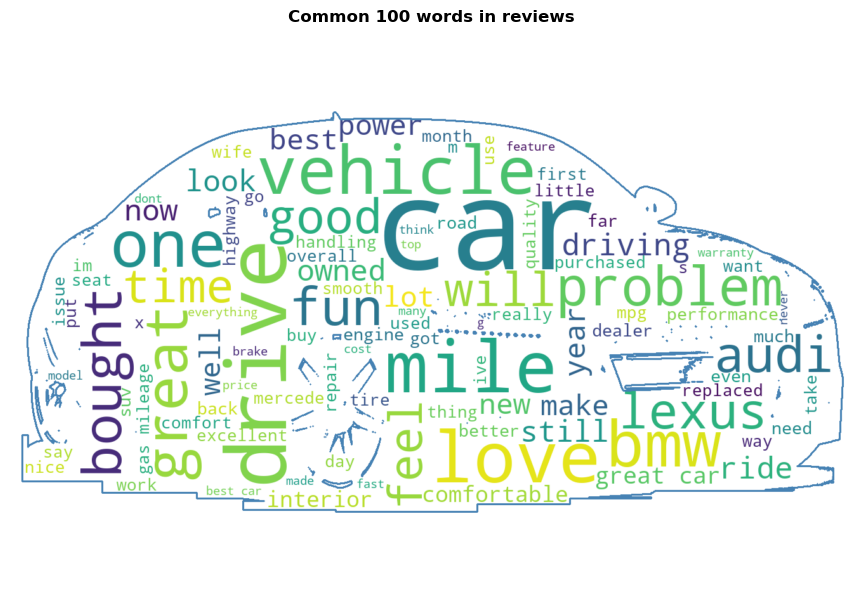

In [26]:
# Join the review.
long_string = ','.join(list(brand.review.values))

# Import the image of a car to have it as mask
car_mask = np.array(Image.open("audi_cloud.png"))

# Create a WordCloud object
wordcloud = WordCloud(background_color="white", mask=car_mask, max_words=100, contour_width=3, contour_color='steelblue')

# Generate a word cloud
wordcloud.generate(long_string)

plt.figure(figsize= (20,7))
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.title("Common 100 words in reviews", pad = 14, weight = 'bold')

plt.show()

In [27]:
wordcloud.to_file("Car_reviw.png")

# Setting up the stop-words

In [28]:
stop_words = stopwords.words('english')
stop_words.extend(['porsche,' 'mercede','comfortsport', 'mercedes','mercedes-benz', 'honda','toyota','audi', 'benz','bentley','lexus',
                  'nissan','volvo','drive','nt','like','vehicle','infiniti','good','miles','corvette','come','edmund','lotus','diego','snake',
                 'porsche', 'cayman','bought','year','minute','chicago','car','home', 'work','think','suv','people','edmunds',
                  'cabriolet','lexuss','japan','husband','baby','range', 'rover','cadillac','cadillacs','michelin','texas','second',
                   'awsome','one','now', 'take', 'give', 'new','levinson','road','love','sedan','wife','sport','bang','tank',
                   'truck','lemon','imho','pathfinder','infinity','convertible','allroad','conv','bike','ski','grocery','mclass'
                  ,'hardtop','club','hubby','child','zoom','test','etc','brain','ashamed','carmax','alpina','rocketship','great','germany',
                  'autobahn','mercedez'])

In [29]:
def lematized_review(text):
    rev_text = nlp(text)
    # Extract lematized words in lower case format if not digits, not punctuation, not stopword, and length not less than 2
    rev_text = ([token.lemma_.lower() for token in rev_text if not token.is_stop and token.text not in stop_words and not token.is_punct and len(token.text) > 3])
    return rev_text

In [30]:
%%time
# Applying the function on the reviews 

brand['review'] = brand['review'].apply(lematized_review)

CPU times: total: 13min 20s
Wall time: 13min 25s


In [31]:
clean_brand_review = brand['review']

In [32]:
clean_brand_review

0        [well, purpose, crossover, see, drive, own, series, pilot, combination, ride, comfortably, stable, quiet, sporty, power, torque, city, country, quality, advanced, technology, feel, spaceship, test, bouncy, suspension, trust, system, drive, ride, smooth, absorb, bump, plus, boring, drive, want, l...
1                                                                                                                                                                                                                           [good, wonderful, technology, adaptable, comfortable, look, nice, detail, wait, mileage]
2                                                                                                                                                                                                                                                                                                                 []
3                                                                        

# Build LDA model

In [33]:
%%time

id2word_1 = corpora.Dictionary(clean_brand_review)

corpus_1 = [id2word_1.doc2bow(review) for review in clean_brand_review]

ldamodel = LdaMulticore(corpus= corpus_1, num_topics =8, id2word=id2word_1,chunksize=2000, passes=50,per_word_topics=True)


CPU times: total: 6min 22s
Wall time: 7min 20s


In [34]:
from pprint import pprint

pprint(ldamodel.show_topics(formatted=False))

[(0,
  [('seat', 0.063523255),
   ('rear', 0.017423749),
   ('room', 0.016549356),
   ('comfortable', 0.014183135),
   ('space', 0.013609807),
   ('interior', 0.01212017),
   ('trunk', 0.01115733),
   ('small', 0.010922299),
   ('ride', 0.008345691),
   ('nice', 0.007941478)]),
 (1,
  [('snow', 0.0653153),
   ('tire', 0.04346287),
   ('winter', 0.03523125),
   ('wheel', 0.009085168),
   ('flat', 0.008963428),
   ('summer', 0.008328907),
   ('live', 0.007893661),
   ('traction', 0.007030464),
   ('season', 0.005999269),
   ('weather', 0.005198292)]),
 (2,
  [('problem', 0.025419958),
   ('replace', 0.017868515),
   ('dealer', 0.0145443985),
   ('time', 0.01323895),
   ('issue', 0.012497492),
   ('tire', 0.009929754),
   ('go', 0.009849592),
   ('repair', 0.009719294),
   ('engine', 0.0096287485),
   ('brake', 0.008687329)]),
 (3,
  [('drive', 0.027450947),
   ('look', 0.021311391),
   ('good', 0.01887237),
   ('ride', 0.016934287),
   ('feel', 0.013967557),
   ('own', 0.012564996),
   (

In [73]:
# Compute Perplexity

#It's a measure of how good the model is. The lower the better. Perplexity is a negative value
print('\nPerplexity: ', ldamodel.log_perplexity(corpus_1))  

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=ldamodel, texts=clean_brand_review, dictionary=id2word_1, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\n Basic Ldamodel Coherence Score: ', coherence_lda)



Perplexity:  -7.6864103496062945

 Basic Ldamodel Coherence Score:  0.49457173538742144


**Notes**

    perplexity is a measurement of how well a probability distribution or probability model predicts a sample. It may be used to compare probability models. A low perplexity indicates the probability distribution is good at predicting the sample.
    
    The coherence score is used in assessing the quality of the learned topics, the closer to 1 the better



# To find the optimum number of topics #

In [41]:

def my_coherence_vals(dictionary, corpus, texts, limit, start, step):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = LdaMulticore(corpus= corpus_1, num_topics =8, id2word=id2word_1,chunksize=2000, passes=50,per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [42]:
# To get the coherence values
model_list, coherence_values = my_coherence_vals(dictionary=id2word_1, corpus=corpus_1, 
                                                 texts=clean_brand_review, start=2, limit=26, step=6)

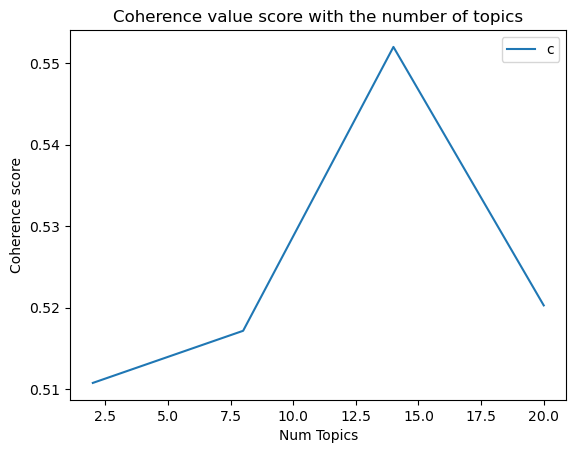

In [43]:
# Show graph for the coherence value scores vs number of topics
limit=26; start=2; step=6;
topics = range(start, limit, step)
plt.plot(topics, coherence_values)
plt.title("Coherence value score with the number of topics")
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [44]:
# Print the coherence scores
for best, cv in zip(topics, coherence_values):
    print("Topic ", best, " has Coherence Value of", round(cv, 4))

Topic  2  has Coherence Value of 0.5107
Topic  8  has Coherence Value of 0.5171
Topic  14  has Coherence Value of 0.552
Topic  20  has Coherence Value of 0.5203


In [45]:
# printing the best topics
optimal_model = model_list[1]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.029*"problem" + 0.021*"replace" + 0.017*"dealer" + 0.014*"time" + '
  '0.014*"issue" + 0.012*"service" + 0.011*"engine" + 0.010*"brake" + '
  '0.010*"go" + 0.009*"repair"'),
 (1,
  '0.013*"tire" + 0.012*"ride" + 0.012*"rattle" + 0.010*"noise" + '
  '0.010*"wheel" + 0.009*"interior" + 0.009*"feel" + 0.008*"look" + '
  '0.008*"seat" + 0.008*"paint"'),
 (2,
  '0.021*"drive" + 0.020*"good" + 0.019*"look" + 0.018*"ride" + 0.015*"luxury" '
  '+ 0.012*"interior" + 0.012*"feel" + 0.012*"own" + 0.010*"well" + '
  '0.010*"performance"'),
 (3,
  '0.016*"seat" + 0.014*"drive" + 0.014*"speed" + 0.011*"tire" + 0.009*"snow" '
  '+ 0.009*"transmission" + 0.008*"feel" + 0.008*"handle" + 0.007*"engine" + '
  '0.007*"little"'),
 (4,
  '0.021*"look" + 0.014*"purchase" + 0.011*"want" + 0.010*"price" + 0.009*"go" '
  '+ 0.008*"performance" + 0.008*"happy" + 0.007*"lease" + 0.007*"experience" '
  '+ 0.007*"love"'),
 (5,
  '0.020*"drive" + 0.020*"mileage" + 0.018*"fuel" + 0.015*"trip" + 0.013*"own" 

# Visualize the topic

In [46]:
pyLDAvis.enable_notebook()
LDAvis_prepared = pyLDAvis.gensim.prepare(ldamodel, corpus=corpus_1, dictionary=id2word_1,sort_topics=False)
LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.041677 -0.203592       1        1   9.179692
1     -0.314669  0.086991       2        1   1.847811
2      0.015753  0.109784       3        1  20.959682
3      0.155238 -0.018046       4        1  24.424202
4     -0.214866 -0.100314       5        1   2.094749
5      0.081614 -0.059094       6        1  21.663389
6      0.131919  0.040511       7        1   8.416139
7      0.103334  0.143759       8        1  11.414336, topic_info=            Term         Freq        Total Category  logprob  loglift
285         seat  6427.000000  6427.000000  Default  30.0000  30.0000
698         tire  3760.000000  3760.000000  Default  29.0000  29.0000
378         snow  1510.000000  1510.000000  Default  28.0000  28.0000
43          good  7000.000000  7000.000000  Default  27.0000  27.0000
179  performance  4034.000000  4034.000000  Default  26.0000  26.0000
..           ...          ...          ...      ...      ...      ...
26          ride   845.962589  7758.268411   Topic8  -4.8638  -0.0457
41          well   755.470318  5824.001983   Topic8  -4.9769   0.1279
85          find   637.494621  3215.191459   Topic8  -5.1467   0.5522
150          car   674.546724  4753.384591   Topic8  -5.0902   0.2177
380           go   655.377484  4407.065516   Topic8  -5.1191   0.2645

[641 rows x 6 columns], token_table=      Topic      Freq           Term
term                                
8759      4  0.933341       abundant
3713      6  0.049879  accelleration
3713      7  0.947697  accelleration
2403      3  0.273324       accident
2403      5  0.633794       accident
...     ...       ...            ...
141       4  0.232921           year
141       5  0.003306           year
141       6  0.020022           year
141       7  0.072191           year
141       8  0.444901           year

[1675 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5, 6, 7, 8])

In [47]:
# Save the visulaization to html
pyLDAvis.save_html(LDAvis_prepared, 'LdaModel_viz.html')

## EXTRACTING MORE MEANING FROM THE REVIEWS

In [57]:
# Define the sentence topics
def sentence_topics(ldamodel=ldamodel, corpus=corpus_1, texts=clean_brand_review):
    # Init output
    topics_df = pd.DataFrame()

    # Looping through the documents to find the main topics
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row[0], key=lambda x: (x[1]), reverse=True)
        
        # look for the Dominant topic, % contribution and Keywords 
        for j, (topic_num, prop_topic) in enumerate(row):
            
            # Diplay the dominant topics
            if j == 0:  
                dom = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in dom])
                topics_df = topics_df._append(pd.Series([int(topic_num), round(prop_topic,2)*100, topic_keywords]), ignore_index=True)
            else:
                break
    topics_df.columns = ['Dominant_Review_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Concatenate the text and the topics_df
    contents = pd.Series(texts)
    topics_df = pd.concat([topics_df, contents], axis=1)
    return(topics_df)


df_topic_sents_keywords = sentence_topics(ldamodel=ldamodel, corpus=corpus_1, texts=clean_brand_review)

# Format
dominant_review_topic = df_topic_sents_keywords.reset_index()
dominant_review_topic.columns = ['Review_No', 'Dominant_Review_Topic', 'Percent_contr_per_topic', 'Review_Keywords', 'Original review']

# Show
dominant_review_topic.head(10)

,Review_No,Dominant_Review_Topic,Percent_contr_per_topic,Review_Keywords,Original review
0,0,3.0,69.000000,"drive, look, good, ride, feel, own, luxury, handle, interior, smooth","[well, purpose, crossover, see, drive, own, series, pilot, combination, ride, comfortably, stable, quiet, sporty, power, torque, city, country, quality, advanced, technology, feel, spaceship, test, bouncy, suspension, trust, system, drive, ride, smooth, absorb, bump, plus, boring, drive, want, l..."
1,1,3.0,61.000001,"drive, look, good, ride, feel, own, luxury, handle, interior, smooth","[good, wonderful, technology, adaptable, comfortable, look, nice, detail, wait, mileage]"
2,2,0.0,12.000000,"seat, rear, room, comfortable, space, interior, trunk, small, ride, nice",[]
3,3,5.0,85.000002,"system, well, control, drive, ride, speed, sound, navigation, feel, feature","[ride, load, technology, steering, tight]"
4,4,5.0,49.000001,"system, well, control, drive, ride, speed, sound, navigation, feel, feature","[good, luxury, perfect, balance, happy, choose, prestige, buy, compare, pace, upcoming, redesign, standard, adaptive, damper, good, comfort, sportiness, desire, taste, soft, floaty, harsh, daily, driver, adaptive, damper, drive, backtoback, backroad, find, quieter, soak, bump, well, fast, time, ..."
5,5,2.0,49.000001,"problem, replace, dealer, time, issue, tire, go, repair, engine, brake","[work, perfectly, know, problem, year, later, update]"
6,6,6.0,41.000000,"performance, quality, excellent, good, luxury, fuel, value, comfort, price, reliability","[exceptionally, balanced, own, alot, car, late, own, recently, cayenne, fall, brand, want, little, sporty, dealer, intend, look, line, consider, sportback, aforementione, context, old, appreciate, performance, perspective, performance, person, actually, street, enjoy, modicum, practicality, car,..."
7,7,5.0,51.999998,"system, well, control, drive, ride, speed, sound, navigation, feel, feature","[rare, find, own, supercharge, german, beast, drive, week, mainly, urban, commute, outshine, previous, make, model, aspect, interior, quality, performance, agility, steering, precision, nimbleness, maneuver, truly, enjoy, find, near, instant, acceleration, useful, overtake, slowpoke, houston, fr..."
8,8,3.0,44.999999,"drive, look, good, ride, feel, own, luxury, handle, interior, smooth","[cayenne, turbo, driver, think, surprise, forget, real, competitor, macan, previous, expect, twice, supercharge, engine, superior, turbo, power, instant, gratifying, complement, good, engine, tune, class, transmission, compose, civilized, traffic, fast, spirited, drive, beat, competitor, hand, g..."
9,9,5.0,94.000000,"system, well, control, drive, ride, speed, sound, navigation, feel, feature","[hold, punch, hold, unfortunately, fly, take, lot, fuel, plus, cruise, trim, tech, feature, paddle]"


In [58]:
# The Dataframe
sent_topics_df = pd.DataFrame()

topics_out = df_topic_sents_keywords.groupby('Dominant_Review_Topic')

for i, j in topics_out:
    sent_topics_df = pd.concat([sent_topics_df,j.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], axis=0)

    
sent_topics_df.reset_index(drop=True, inplace=True)

# Format
sent_topics_df.columns = ['Topic_Num', "Percent_contr_per_topic", "Review_Keywords", "Original review"]

# Display the 8 topics
sent_topics_df.head(8)

,Topic_Num,Percent_contr_per_topic,Review_Keywords,Original review
0,0.0,98.000002,"seat, rear, room, comfortable, space, interior, trunk, small, ride, nice","[real, sport, sell, go, ahead, factory, order, roadster, read, review, satisfied, throttle, response, phenomenal, little, touch, go, handle, feel, nimble, taut, sharp, turnin, engine, smooth, silk, produce, perfect, exhaust, note, sadly, breakin, period, feel, beast, hood, wait, totally, thick, ..."
1,1.0,95.999998,"snow, tire, winter, wheel, flat, summer, live, traction, season, weather","[disappointing, performance, step, hard, long, accelerate, happen, feel, time, fine, rely, adequate, acceleration, quickly, highway, pass, car, slow, transmission, jerk, downshift, unexpectedly, actually, upshift, jerk, forward, service, say, design]"
2,2.0,99.000001,"problem, replace, dealer, time, issue, tire, go, repair, engine, brake","[money, impress]"
3,3.0,99.000001,"drive, look, good, ride, feel, own, luxury, handle, interior, smooth","[excellent, versus]"
4,4.0,97.000003,"light, door, go, accident, bumper, holder, save, paint, body, color","[handle, attention, drive]"
5,5.0,99.000001,"system, well, control, drive, ride, speed, sound, navigation, feel, feature","[comportable, easy, ride, long, trip]"
6,6.0,98.000002,"performance, quality, excellent, good, luxury, fuel, value, comfort, price, reliability",NaN
7,7.0,99.000001,"year, purchase, own, drive, maintenance, service, look, change, reliable, time","[look, sleek, fast, definitely, turn, head, awesome, stereo, loud, changer, load, unexpected, nice, extra, heat, steering, wheel, power, sunshade, memory, seat, expensive, maintain, little, item, cost, part, service]"


## Topic modelling of each brand ##

The previous LDA model that I ran was for the reviews of all the brands. Here I want to understand and visualize 6 topics in each brand. This could help to understand the discussion in the review of each brand.

In [59]:
# saving the review of each brand in a DataFrame
audi_df = ([sent for sent in brand.loc[brand['make'] == 'Audi', 'review']])
bmw_df = ([sent for sent in brand.loc[brand['make'] == 'BMW', 'review']])
mercedes_df = ([sent for sent in brand.loc[brand['make'] == 'Mercedes-Benz', 'review']])
lexus_df = ([sent for sent in brand.loc[brand['make'] == 'Lexus', 'review']])
inifiniti_df = ([sent for sent in brand.loc[brand['make'] == 'INFINITI', 'review']])

In [60]:
%%time

# Defining a function to get the topics and visualize them 
def each_brand(text):

    # Create Dictionary
    id2word_2 = corpora.Dictionary(text)

    # Create Corpus: Term Document Frequency
    corpus_2 = [id2word_2.doc2bow(review) for review in text]
    
    # Here I decided to reduce the number of topics to only six for each brand
    model = LdaMulticore(corpus=corpus_2, num_topics = 6, id2word=id2word_2,chunksize=2000, passes=80,per_word_topics=True)
    
    LDAvis_prepared = pyLDAvis.gensim.prepare(model, corpus=corpus_2, dictionary=id2word_2,sort_topics=False)

    return LDAvis_prepared

CPU times: total: 0 ns
Wall time: 0 ns


In [61]:
# Fitting the LDA model on each brand to visual the topics
Audi_lda = each_brand(audi_df)
lexus_lda = each_brand(lexus_df)
bmw_lda = each_brand(bmw_df)
mercedes_lda = each_brand(mercedes_df)
inifiniti_lda = each_brand(inifiniti_df)

Audi Topics Explanation

In [62]:
# Visualize the LDA model on Audi reviews
Audi_lda

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.049366  0.033051       1        1   7.729225
1      0.068657  0.002026       2        1   5.371660
2     -0.019552 -0.127147       3        1  24.604813
3      0.126812  0.111881       4        1   2.981691
4     -0.022690 -0.124836       5        1  31.633260
5     -0.202593  0.105024       6        1  27.679352, topic_info=             Term         Freq        Total Category  logprob  loglift
13          drive  2101.000000  2101.000000  Default  30.0000  30.0000
844       replace   854.000000   854.000000  Default  29.0000  29.0000
503        repair   629.000000   629.000000  Default  28.0000  28.0000
158        dealer   809.000000   809.000000  Default  27.0000  27.0000
285          seat  1057.000000  1057.000000  Default  26.0000  26.0000
..            ...          ...          ...      ...      ...      ...
356  transmission   258.625855   522.680892   Topic6  -5.3196   0.5809
212        change   239.723286   447.512815   Topic6  -5.3955   0.6603
19            own   265.663567  1050.216264   Topic6  -5.2927  -0.0900
13          drive   246.763654  2101.407411   Topic6  -5.3665  -0.8574
17           look   245.633534  1649.298081   Topic6  -5.3711  -0.6198

[507 rows x 6 columns], token_table=       Topic      Freq                    Term
term                                          
12162      4  0.846396                        
12164      4  0.846396                        
196        1  0.018695            acceleration
196        2  0.082794            acceleration
196        3  0.451361            acceleration
...      ...       ...                     ...
141        2  0.025363                    year
141        3  0.139494                    year
141        4  0.013738                    year
141        5  0.301181                    year
141        6  0.455470                    year

[1222 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5, 6])

In [63]:
# Save the visualization to html
pyLDAvis.save_html(Audi_lda, 'Audi_viz.html')

Lexus Topics Explanation

In [64]:
# Visualize the LDA model on Lexus reviews
lexus_lda

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.067687 -0.039201       1        1  21.856211
1     -0.046000 -0.042895       2        1   8.366981
2     -0.046283  0.048119       3        1  28.281415
3     -0.044367 -0.084267       4        1   8.459027
4      0.202605 -0.031576       5        1  20.724107
5      0.001731  0.149821       6        1  12.312258, topic_info=          Term         Freq        Total Category  logprob  loglift
177       good  1367.000000  1367.000000  Default  30.0000  30.0000
543     system   987.000000   987.000000  Default  29.0000  29.0000
58        seat  1279.000000  1279.000000  Default  28.0000  28.0000
124    problem  1069.000000  1069.000000  Default  27.0000  27.0000
49      luxury  1117.000000  1117.000000  Default  26.0000  26.0000
..         ...          ...          ...      ...      ...      ...
64        time    91.957605   927.554542   Topic6  -5.4371  -0.2166
47      little    79.098815   554.516125   Topic6  -5.5878   0.1472
13        need    83.723082   759.486583   Topic6  -5.5309  -0.1106
38        find    77.892137   585.388350   Topic6  -5.6031   0.0776
390  excellent    72.544254   623.371404   Topic6  -5.6743  -0.0564

[490 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
540       1  0.292714  absolutely
540       2  0.269108  absolutely
540       3  0.250224  absolutely
540       4  0.051933  absolutely
540       5  0.084982  absolutely
...     ...       ...         ...
28        3  0.064996        year
28        4  0.142991        year
28        5  0.314979        year
28        6  0.028998        year
739       4  0.896744       zippy

[1215 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5, 6])

In [65]:
# Save the visulaization to html
pyLDAvis.save_html(lexus_lda, 'Lexus_viz.html')

BMW Topics Explanation

In [66]:
# Visualize the LDA model on BMW reviews
bmw_lda

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.119465  0.070702       1        1   8.891171
1      0.174448 -0.017207       2        1  22.446224
2     -0.069144 -0.011225       3        1   6.907004
3     -0.052107 -0.043564       4        1  10.447403
4     -0.117552  0.134837       5        1   3.976657
5     -0.055110 -0.133542       6        1  47.331541, topic_info=        Term         Freq        Total Category  logprob  loglift
51   problem  1631.000000  1631.000000  Default  30.0000  30.0000
149  replace  1175.000000  1175.000000  Default  29.0000  29.0000
125     time  1642.000000  1642.000000  Default  28.0000  28.0000
131    drive  3296.000000  3296.000000  Default  27.0000  27.0000
326   repair   778.000000   778.000000  Default  26.0000  26.0000
..       ...          ...          ...      ...      ...      ...
110  mileage   483.891400   723.682834   Topic6  -5.4904   0.3455
518     fast   501.623148   793.482787   Topic6  -5.4544   0.2894
586    speed   519.921019   876.419367   Topic6  -5.4186   0.2258
213      get   510.648669   844.143982   Topic6  -5.4366   0.2454
83      year   540.447611  1346.228167   Topic6  -5.3798  -0.1647

[509 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
3190      2  0.027846   absolute
3190      3  0.306308   absolute
3190      5  0.069615   absolute
3190      6  0.598692   absolute
6141      2  0.170245  accompany
...     ...       ...        ...
83        2  0.392207       year
83        3  0.016342       year
83        4  0.076510       year
83        5  0.023027       year
83        6  0.401121       year

[1216 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5, 6])

In [67]:
# Save the visualization to html
pyLDAvis.save_html(bmw_lda, 'BMW_viz.html')

Mercedes_Benz Topics Explanation

In [68]:
# Visualize the LDA model on Mercedes reviews
mercedes_lda

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.037002  0.112695       1        1   6.103557
1     -0.100088  0.053640       2        1   5.183237
2     -0.034802 -0.063463       3        1  17.438699
3      0.223363  0.017222       4        1  31.612814
4     -0.043893 -0.070860       5        1  10.311964
5     -0.007577 -0.049233       6        1  29.349730, topic_info=        Term         Freq        Total Category  logprob  loglift
107     good  1330.000000  1330.000000  Default  30.0000  30.0000
80     drive  2394.000000  2394.000000  Default  29.0000  29.0000
19      look  1849.000000  1849.000000  Default  28.0000  28.0000
143  replace  1007.000000  1007.000000  Default  27.0000  27.0000
178      own  1396.000000  1396.000000  Default  26.0000  26.0000
..       ...          ...          ...      ...      ...      ...
444  mileage   255.358586   680.875261   Topic6  -5.5371   0.2452
50    handle   256.731802   800.030333   Topic6  -5.5318   0.0893
224      car   260.012121   942.682350   Topic6  -5.5191  -0.0621
113  quality   256.976671   917.441231   Topic6  -5.5308  -0.0467
228   little   249.951042   751.043345   Topic6  -5.5585   0.1257

[506 rows x 6 columns], token_table=       Topic      Freq        Term
term                              
11007      5  0.883102          \r
2523       4  0.252033     acquire
2523       5  0.756100     acquire
3488       1  0.848002       addon
1000       6  0.969108  adjustable
...      ...       ...         ...
239        2  0.006507        year
239        3  0.236703        year
239        4  0.492114        year
239        5  0.190338        year
239        6  0.065073        year

[1228 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5, 6])

In [69]:
# Save the visualization to html
pyLDAvis.save_html(mercedes_lda, 'mercedes_viz.html')

INFINITI Topics Explanation

In [70]:
# Visualize the LDA model on Infiniti reviews
inifiniti_lda

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.040120  0.114336       1        1   6.384988
1     -0.047641 -0.013898       2        1  17.832988
2     -0.084354 -0.060608       3        1  23.470861
3      0.224726 -0.027517       4        1  19.314578
4     -0.061493 -0.072551       5        1  21.054234
5      0.008882  0.060239       6        1  11.942351, topic_info=        Term         Freq        Total Category  logprob  loglift
618  replace   506.000000   506.000000  Default  30.0000  30.0000
532  problem   815.000000   815.000000  Default  29.0000  29.0000
18     drive  1548.000000  1548.000000  Default  28.0000  28.0000
415     seat   979.000000   979.000000  Default  27.0000  27.0000
855  service   365.000000   365.000000  Default  26.0000  26.0000
..       ...          ...          ...      ...      ...      ...
62    smooth    59.912382   358.997417   Topic6  -5.5471   0.3346
31        go    65.716254   532.709028   Topic6  -5.4546   0.0325
71      tire    62.877017   483.686956   Topic6  -5.4988   0.0848
122  control    59.538007   386.317487   Topic6  -5.5533   0.2550
154     nice    61.062595   518.910732   Topic6  -5.5281  -0.0148

[518 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
4644      6  0.923345      abrupt
778       1  0.026893  accelerate
778       2  0.242036  accelerate
778       3  0.255483  accelerate
778       4  0.013446  accelerate
...     ...       ...         ...
572       4  0.428510        year
572       5  0.317154        year
572       6  0.057792        year
6464      6  0.886518      yearly
2327      2  0.898072       zippy

[1218 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5, 6])

In [71]:
# Save the visualization to html
pyLDAvis.save_html(inifiniti_lda, 'Infiniti_viz.html')